<img src="https://upload.wikimedia.org/wikipedia/commons/6/63/ETH_Z%C3%BCrich_wordmark.svg" width="200" height="200" align="left">
<br />
<br /><br />
<div align="right"> <b/> FS 2022
<br />
    
## <div align="center"> Project & Seminars: Python for Science & Machine Learning

---

# <div align="center"> Exercise 8th week: More Machine Learning with PyTorch

This exercise session is a continuation of the previous one. There are 2 exercises. In the first we calculate and plot the confusion matrix of a LeNet. The second one is applying the learned concepts on a new datasets where you have to use the learned functions.


## 1. Confusion Matrix
In this exercise, we calculate and plot the confusion matrix of a LeNet.  
&nbsp;  
First we load all packages which may be required for this exercise.

In [2]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install opencv-python

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import itertools

import pandas as pd

Now we load the datasets.

In [4]:
batch_size = 50
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784))
     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Exercise 1.1: Build forward pass**  
We have already used LeNet-5 in the last exercise and discussed it during the lecture. Try to recreate the forward pass without looking it up and without creating a `nn.Flatten()` module. Instead, you can use `torch.flatten()` directly in the forward pass. Just remember to set the starting dimension to 1 so that the batch does not get flattened.  
The forward pass is `convolution -> pooling -> convolution -> pooling -> flatten -> linear -> linear -> linear`. Don't forget to use `F.relu` after every neural layer except the last.  
When done, you can look up the model from the previous exercise to check that your forward pass is correct.

In [5]:
class LeNet(nn.Module):
    # here we define the modules
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    # here we define the forward pass
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

PyTorch models are dynamic computational graphs and therefore very flexible. Multiple paths and outputs can be created in the forward pass, functions and conditions can be used, a wide range of input shapes and types can be handled simultaneously and much more. However, keep in mind that for backpropagation it needs to be differentiable and to avoid creating bottlenecks that slow down the model, such as long loops.

**Exercise 1.2: Initialize the net and print it**  
Now initialize the net and print it.

In [7]:
net = LeNet()

print(net)

print(net.fc3.bias)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Parameter containing:
tensor([-0.0603, -0.0911, -0.0888,  0.0797,  0.0603,  0.0955,  0.0206,  0.1037,
         0.0832, -0.0846], requires_grad=True)


As we can see, this shows us the modules in the order they were defined. This is useful to see how specific modules can be accessed. For example the last layer's biases can be accessed via `net.fc3.bias`.  
Now we are interested in the model structure. Since PyTorch models are dynamic computational graphs, their structure is flexible and only determined during a forward pass. For this we could use hooks but fortunately other people have already implemented this. Install the `torchinfo` library.

In [8]:
!pip install torchinfo

**Exercise 1.3: Model summary**  
Use `torchinfo` to print a model summary for an input with the same shape as a single CIFAR-10 image. Use the parameter `col_names` if you want to print more than just output shape and parameters. Look at the readme to figure out how: https://github.com/TylerYep/torchinfo

In [13]:
from torchinfo import summary

summary(net, input_size=(1,3,32,32), col_names=("input_size", "output_size", "num_params", "mult_adds"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
LeNet                                    [1, 3, 32, 32]            [1, 10]                   --                        --
├─Conv2d: 1-1                            [1, 3, 32, 32]            [1, 6, 28, 28]            456                       357,504
├─MaxPool2d: 1-2                         [1, 6, 28, 28]            [1, 6, 14, 14]            --                        --
├─Conv2d: 1-3                            [1, 6, 14, 14]            [1, 16, 10, 10]           2,416                     241,600
├─MaxPool2d: 1-4                         [1, 16, 10, 10]           [1, 16, 5, 5]             --                        --
├─Linear: 1-5                            [1, 400]                  [1, 120]                  48,120                    48,120
├─Linear: 1-6                            [1, 120]                  [1, 84]                   10,164                    10,164

Here we see the strength of convolutional layers. They dominate MAC (Multiply Accumulate operations) while the linear layers dominate the parameter count. Try to calculate the parameters for any layer by hand. Do you get the same result?  
&nbsp;  
Keep in mind that the number of parameters and especially MAC can be wrong for models with unusual structure. `fvcore`'s `FlopCountAnalysis` is the most reliable way to count MAC that I have found so far apart from measuring them directly.  
&nbsp;  
Since training is slow, we will load a pretrained model this time. The file is called `lenet5.pth` and can be found in the lecture folder on gitlab.

In [16]:
net.load_state_dict(torch.load('lenet5.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

**Exercise 1.4: Confusion matrix**  
Calculate the confusion matrix for the pretrained model. As output we want a two dimensional tensor where the row index is the true class while the column index is the predicted class. You can check the code from week 7's Exercise 6.1 as starting point if you are stuck.

In [18]:
def conf(net, dataloader):
    # create a tensor to store the confusion matrix
    cm = torch.zeros(10,10,dtype=torch.int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            
            for i in range(len(labels)):
                cm[labels[i], predicted[i]] += 1

    return cm

cm = conf(net, testloader)

Once the confusion matrix is calculated, we can plot it using the following code.

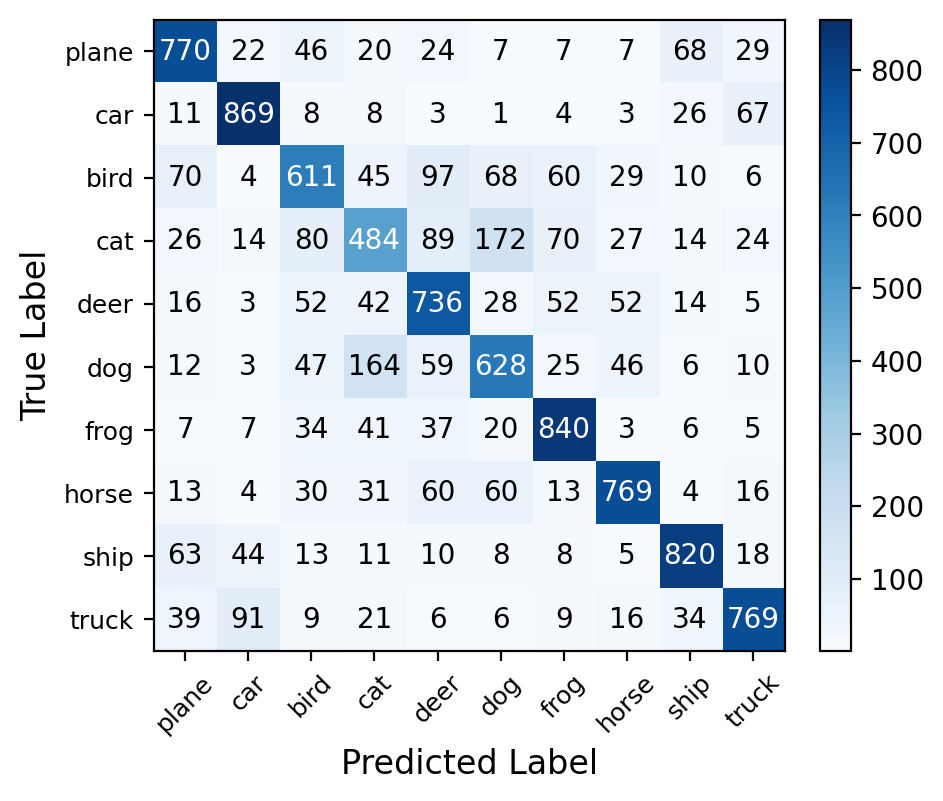

In [19]:
# create figure
plt.figure(figsize=(4.5, 4.5), dpi=200)

# plot confusion matrix colormap
im = plt.imshow(cm, interpolation='nearest', cmap='Blues')

# plot numbers on top
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', 
             color="white" if cm[i, j] > thresh else "black")

# plot ticks, labels and color bar
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, fontsize=9)
plt.yticks(tick_marks, classes, fontsize=9)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.colorbar(im, fraction=0.04524, pad=0.05)

plt.show()

## 2. Mobile Price prediction:

The dataset is in the folder MobilePrice

The columns are explained in metadata.txt if you want to know more about them. Split the data into X and y (price range)

In [29]:
# !pip install sklearn.model
# import sklearn.model

from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 66.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 93.3 MB/s eta 0:00:00


ModuleNotFoundError: No module named 'sklearn.model'

In [30]:
# read the data and split into training data and labels
train_dataset=pd.read_csv('MobilePrice/train.csv')
train_dataset.info()

#Insert code here. 
X_train=train_dataset=pd.read_csv('MobilePrice/train.csv')
y_train=train_dataset['price_range']

X_train.head()

#I did not manage to import the file from above this is wy I am not able to execute the code from here

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


As we are doing a classification, we need to check if the data is balanced. Check if each of the price ranges appears similar times using a pie plot or bar plot

([<matplotlib.patches.Wedge at 0x7f52c4124520>,
 [Text(0.7778174593052024, 0.7778174593052023, '1'),
  Text(-0.7778174593052023, 0.7778174593052024, '2'),
  Text(-0.7778174593052025, -0.7778174593052023, '3'),
  Text(0.7778174593052022, -0.7778174593052025, '0')])

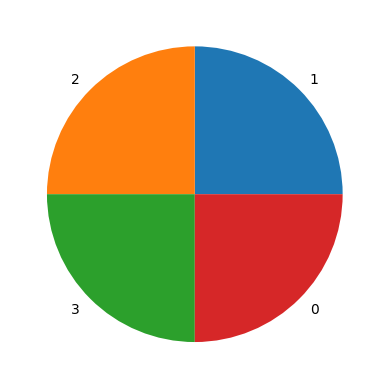

In [31]:
# Insert Code here


plt.pie(y_train.value_counts(), labels=y_train.value_counts().index)

Normalize the data such that all the inputs are between 0-1 (hint: StandardScaler) and adapt the y-labels such that they can be used in a neural network (hint: One-hot-encoding)

In [32]:

x_train_t = StandardScaler().fit_transform(X_train)
print(y_train)

#Enter your code here


NameError: name 'StandardScaler' is not defined

Do a test  train split using the function train_test_split

In [33]:
#Enter your code here


X_train, y_train = train_test_split(torch.from_numpy(x_train_t).float(), torch.from_numpy(y_train), test_size=0.2, random_state=53)

NameError: name 'train_test_split' is not defined

Create a neural network for this task.

In [ ]:
class PricingModel(nn.Module):
    # here we define the modules
    def __init__(self):
        super().__init__()

        #insert code here
        
        self.fc1 = nn.Linear(20,10)
        self.fc2 = nn.Linear(10,4)

    # here we define the forward pass
    def forward(self, x):
        # INSERT CODE HERE

        return x


This is the standard training loop we provide for you:

In [ ]:
net= PricingModel()

# Make a Tensordataset out of the training data and labels using the TensorDataset class (read the documentation)
#Insert code here
train_dataset = ...
test_dataset = ...

# Make a dataloader out of the dataset using the DataLoader class (read the documentation), test
train_loader=...
test_loader=...


# this is our loss
criterion = nn.CrossEntropyLoss()

# this is our optimizer: ADAM
optimizer = optim.Adam(net.parameters(), lr=0.001)

# collect  loss for every epoch
metric = []

# We start with 400 epochs but change depending on your loss curve and model size
for epoch in range(400):
    epoch_loss = []
    
    for i, data in enumerate(train_loader, 0):
        # get the inputs from data, which is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = net(inputs)
        # calculate loss
        loss = criterion(outputs, labels)
        # backpropagation
        loss.backward()
        optimizer.step()

        # collect loss
        epoch_loss.append(loss.item())

    # print loss every 100 epochs
    if epoch % 100 == 0:
        print('[%d] loss: %.3f' % (epoch + 1, loss.item()))
    
    # collect loss
    metric.append(np.mean(epoch_loss))
    




In [ ]:
# This plots the loss curve
plt.figure(figsize=(10,6))
plt.plot(metric)
plt.ylabel('Loss')
plt.show()

Now test the Model against the test data (and train data)-

Do inference on model and print the confusion matrix and classification report once for the training data and once for the test data. Is the model overfitting the trainingdata?

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# INSERT CODE HERE


# I tried my best but from some point I just got nothing running anymore and did not find my issue, I'm sorry!!

To see the overfitting already during the training, implement a second metric during the training that checks the test data every few epochs. Add the metric in the plot above


Test out different Model sizes (number of hidden layers or hidden neurons). For this task a neural network is generally too much and a simple ML model would be sufficient but we still try it here with a NN to get used to the syntax of it